# Iterative method:

Modifying the method from the main ILC notebook and the regions from WMAP_regions:

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

def rescale(map, NSIDE):
    
    rescaled = hp.ud_grade(map, NSIDE)
    
    return rescaled

WMAP regions:

In [2]:
N_obs = hp.read_map("wmap_ilc_rgn_defn_yr1_v1.fits", dtype=None, field=1)
#N_obs = hp.read_map("wmap_ilc_rgn_defn_3yr_v2.fits", dtype=None, field=1)

def mask_finder_full():
    
    vals_mask = np.zeros((12,3145728))
    
    for i in range(0,3145728):             # all of N_obs
        for j in range(12):                # all possible values of N_obs
            if N_obs[i] == j:
                vals_mask[j,i] = 1
    
    return vals_mask

all_masks = mask_finder_full()
all_masks_unblurred = all_masks


def masking(input_map, mask_section):
    
    masked      = hp.ma(input_map)
    masked.mask = np.logical_not(all_masks[mask_section,:])
    
    #input_map.mask = np.logical_not(all_masks[mask_section,:])
    output_map  = masked.filled()
    
    return output_map

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/idies/miniconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("tab20"))
  newcm.set_over(newcm(1.0))
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("tab20"))
  newcm.set_under(bgcolor)
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a r

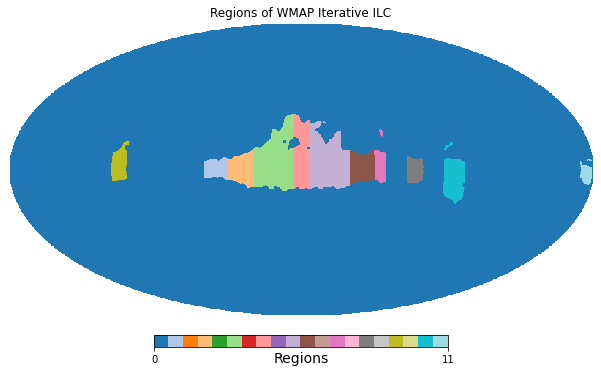

In [3]:
# mask map for clarity

hp.mollview(N_obs, unit='Regions', cmap='tab20', title="Regions of WMAP Iterative ILC")

In [4]:
np.shape(all_masks)

(12, 3145728)

## Smoothing the maps

In [5]:
smoothed_masks = np.zeros((np.shape(all_masks)))

for i in range(12):
    smoothed_masks[i] = hp.smoothing(all_masks[i], fwhm=(1.5*np.pi/180), verbose=False)

all_masks = smoothed_masks.round(5)
#all_masks = np.where(all_masks==1,-1.6375e+30, all_masks)

#hp.mollview(all_masks_unblurred[0], norm='hist')
#hp.mollview(all_masks[0], norm='hist')

[0.99991 0.99991 0.99991 ... 0.9999  0.99991 0.99991]


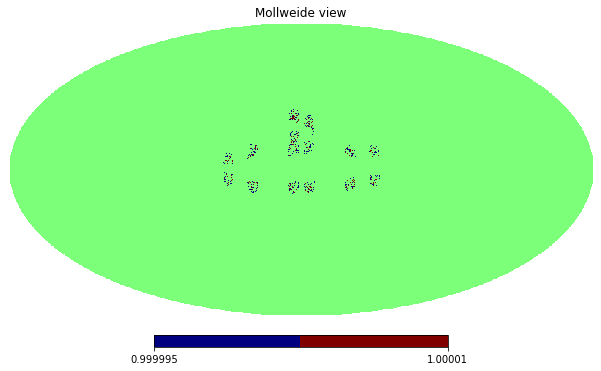

In [6]:
sum_all         = np.sum(all_masks_unblurred, axis=0)
sum_all_blurred = np.sum(all_masks, axis=0)

#hp.mollview(sum_all, norm='hist')
#hp.mollview(sum_all_blurred, norm='hist')

print(sum_all_blurred)

hp.mollview(sum_all_blurred, norm='hist', min=0.999995, max=1.000005, cmap='jet')

## Iteration steps:

1. Produce $a_{lm}$ for a region
2. Obtain weights for that region across the input maps
3. Use weights to superpose $a_{lm}$ of the whole sky
4. Convert $a_{lm}$ to sky map (best cleaned in this region now)
5. Replace this region of all the input maps with the cleaned region
    - take care to apply the correct beam resolutions for each band
6. Repeat for all regions

In [7]:
def harmonic(pmap, LMAX):
    # step 1 - convert maps to harmonic space, i.e the form s(ℓ,m).
    
    hmap = hp.map2alm(pmap, lmax=LMAX)
    
    return hmap

def harmonic_masked(pmap, LMAX, region):
    
    """Takes pixel maps and converts them to masked harmonic ones"""
    
    # step 1 - mask map into only the required region (0-11, wrt 1-12 of WMAP)
    
    masked = hp.ma(pmap)
    output_map = masked * all_masks[region]
    
    # step 2 - convert maps to harmonic space, i.e the form s(ℓ,m).
    
    hmap = hp.map2alm(output_map, lmax=LMAX)
    
    return hmap

In [8]:
def cov_inv(hmaps):                                  # unchanged from ILC method
    
    """Calculates the covariance of the input maps, taking care to remove ℓ=0"""
    
    maps_stack = np.stack(hmaps)
    
    # C is the covariance matrix of the observations in mode (ℓ,m)
    # but covariance is the sum of all modes where l != 0
    #
    # Healpix stores lm data ordered by m
    # I.e. if ℓmax is 16, the first 16 elements are m=0,ℓ=0−16, then the following 15 elements are m=1,ℓ=1−16,
    # then m=2,ℓ=2−16 and so on until the last element, the 153th, is m=16,ℓ=16.
    #
    # only m=0, l=0 to be discarded, the first value of each row
    
    stack_cut = np.delete(maps_stack, obj=0, axis=1)
    
    C_lm = np.cov(stack_cut)
    C_inv = np.linalg.inv(C_lm)
    
    return C_inv

In [9]:
def weight_gen(C_inv):                                  # unchanged from ILC method
    
    """Calculates the weights using the ILC method and checks they roughly
    equal 1 (can sometimes be out by ~10**-10 and less)"""
    
    # step 3 - calculate the weights
    
    # numerator:
    # ∑_j [C−1]_ij
    
    numerator = np.sum(C_inv, axis=0)  
    
    # denominator: 
    # ∑_i ∑_j [C−1]_ij       is this the same as ∑_i [numerator] ?
    
    denominator = np.sum(numerator) 
    
    w = numerator / denominator

    
    #check the weight requirement:
    
    w_tot = np.sum(w)
    
    #print("The total weight is:",w_tot,)
    
    #if w_tot == 1:
    #    print("Weights calculated successfuly")
    #elif w_tot.imag < (10**10):
    #    print("Small weighting error, probably negligible")
    #    # sometimes produces imag weights in the 10**-19 or -20 range, these are probably fine
    #else:
    #    print("There is an error in weight calculation")
        
    return w

In [10]:
def output_map(hmaps, w, LMAX, NSIDE):                  # unchanged from ILC method
    
    """Applies the previous weights to the series of harmonic maps, then generates a pixel map
    of the combined group"""
    
    weighted_maps = np.empty(shape=np.shape(hmaps), dtype=np.complex_)    
    # gives the correct shape of hmaps, gets overwritten below
    
    for i in range(len(w)):
        row_slice = hmaps[i]
        
        # weighted_maps[i] = row_slice * w[i]
        # ComplexWarning: Casting complex values to real discards the imaginary part
        
        # solved by making the weighted_maps array complex
        
        weighted_maps[i] = row_slice * w[i]
        
    hmap = np.sum(weighted_maps, axis = 0)
    
    fin_map = hp.alm2map(hmap, lmax=LMAX, nside= NSIDE, verbose=False)
    
    return fin_map

In [11]:
def region_multi_replace(pmaps, fin_map, region):
    
    """take the targetted region from the cleaned map and 
    apply it to the initial maps, taking care of the beam resolution"""
    
    #mask_region = hp.mask_good(all_masks[region], badval=1)
    
    
    masked = hp.ma(fin_map)
    masked.mask  = np.logical_not(all_masks[region,:])
    clean_region = masked.filled(fill_value=0)
    #clean_region = masked.filled(fill_value=0) * all_masks[region]
    
    # select all but that region from the initial maps
    
    maps_stack      = np.stack(pmaps)
    pmap_holes      = np.zeros(np.shape(maps_stack))    # series of maps with the region removed
    pmaps_corrected = np.zeros(np.shape(maps_stack))    # the fully swapped over maps
    blur            = all_masks[region]*(all_masks_unblurred[region].astype('bool'))
    
    for i in range(len(map_set)):
        row_slice          = maps_stack[i,:]        
        masked_pmap        = hp.ma(row_slice)
        
        
        
        #masked_pmap.mask   = all_masks[region]
        masked_pmap.mask = np.ceil(all_masks[region]).astype('int') * blur 
        pmap_holes[i,:]    = masked_pmap.filled(fill_value=0)# - blur
        pmaps_corrected[i] = pmap_holes[i,:] + clean_region
        
    return pmaps_corrected

In [12]:
# 2 - generate Beam functions for each alm
FWHM_name_set = ["30GHz","70GHz","143GHz","353GHz"]
FWHM_arc = (32.239, 13.252, 7.248, 4.818)                # arcmin
FWHM_set = [i * (np.pi / (60*180)) for i in FWHM_arc]    # radians
names = ["j=0","j=1","j=2","j=3","j=4","j=5","j=6","j=7","j=8","j=9","j=10","j=11","j=12"]

def res_change(pmap, resolution_arc):
    
    '''This is just adding more smoothing to the maps, not matching them to the necessary smoothing.
    Not sure how to get around it though.'''
    
    resolution_rad = (resolution_arc * np.pi ) / (60*180)
    smoothed_map = hp.smoothing(pmap, fwhm=resolution_rad, verbose=False)

    return smoothed_map

if 0==1:
    def res_change(pmap, resolution_arc):
        
        '''Applies a scaling beam width wrt the smallest FWHM_arc,
        should mean they are all the same resolution'''

        #FWHM_ratio = FWHM_arc[FWHM_arc.index(resolution_arc)]**2 - FWHM_arc[-1]**2
        #FWHM_ratio = resolution_arc**2 - FWHM_arc[-1]**2
        FWHM_ratio = FWHM_arc[0] / resolution_arc 
        FWHM_ratio_rad = FWHM_ratio*(np.pi / (60*180))
        
        print(FWHM_name_set[FWHM_arc.index(resolution_arc)])
        print('fwhm_ratio (arcmin):',FWHM_ratio)
        print('scale ratio (rad):',FWHM_ratio_rad)
        
        
        
        pmap = hp.smoothing(pmap, fwhm=FWHM_ratio_rad, pol=False, lmax=LMAX, verbose=True)

        return pmap

All functions defined, onto creating the maps:

In [13]:
CMB_30_p  = hp.read_map("LFI_SkyMap_030-field-IQU_1024_R3.00_full.fits",     dtype=None, verbose=False)
CMB_70_p  = hp.read_map("LFI_SkyMap_070-field-IQU_1024_R3.00_full.fits",     dtype=None, verbose=False)
CMB_143_p = hp.read_map("HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits",     dtype=None, verbose=False)
CMB_353_p = hp.read_map("HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full.fits", dtype=None, verbose=False)


synthetic=1
if synthetic==1:
    CMB_30_p  = hp.read_map("synthetic_30GHz_m.fits", dtype=None, verbose=False)
    CMB_70_p  = hp.read_map("synthetic_70GHz_m.fits", dtype=None, verbose=False)
    CMB_143_p = hp.read_map("synthetic_143GHz_m.fits", dtype=None, verbose=True)
    CMB_353_p = hp.read_map("synthetic_353GHz_m.fits", dtype=None, verbose=False)


NSIDE = 512    # limited by the WMAP region mask, could probably just scale the mask up
LMAX  = 2048

CMB_30_p  = rescale(CMB_30_p, NSIDE)
CMB_70_p  = rescale(CMB_70_p, NSIDE)
CMB_143_p = rescale(CMB_143_p, NSIDE)
CMB_353_p = rescale(CMB_353_p, NSIDE)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify

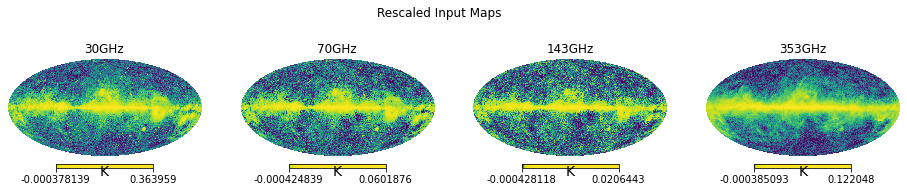

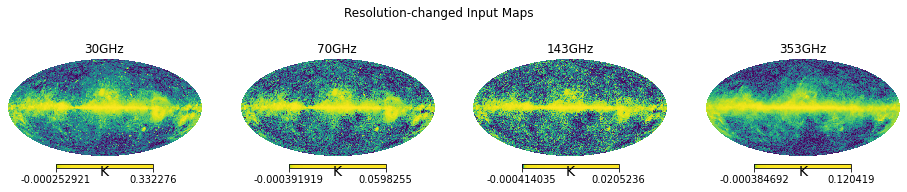

In [14]:
fig = plt.figure(figsize=(16,2.8))
plt.suptitle('Rescaled Input Maps')
plt.subplot(1,4,1)
hp.mollview(CMB_30_p, norm='hist', title='30GHz', unit='K', hold=True)
plt.subplot(1,4,2)
hp.mollview(CMB_70_p, norm='hist', title='70GHz', unit='K', hold=True)
plt.subplot(1,4,3)
hp.mollview(CMB_143_p, norm='hist', title='143GHz', unit='K', hold=True)
plt.subplot(1,4,4)
hp.mollview(CMB_353_p, norm='hist', title='353GHz', unit='K', hold=True)

CMB_30_p  = res_change(CMB_30_p,  FWHM_arc[0])
CMB_70_p  = res_change(CMB_70_p,  FWHM_arc[1])
CMB_143_p = res_change(CMB_143_p, FWHM_arc[2])
CMB_353_p = res_change(CMB_353_p, FWHM_arc[3])


CMB_30_h_init  = harmonic(CMB_30_p, LMAX)
CMB_70_h_init  = harmonic(CMB_70_p, LMAX)
CMB_143_h_init = harmonic(CMB_143_p, LMAX)
CMB_353_h_init = harmonic(CMB_353_p, LMAX)

initial_hmaps = (CMB_30_h_init, CMB_70_h_init, CMB_143_h_init, CMB_353_h_init)    # necessary to apply the r0 weight to

fig = plt.figure(figsize=(16,2.8))
plt.suptitle('Resolution-changed Input Maps')
plt.subplot(1,4,1)
hp.mollview(CMB_30_p, norm='hist', title='30GHz', unit='K', hold=True)
plt.subplot(1,4,2)
hp.mollview(CMB_70_p, norm='hist', title='70GHz', unit='K', hold=True)
plt.subplot(1,4,3)
hp.mollview(CMB_143_p, norm='hist', title='143GHz', unit='K', hold=True)
plt.subplot(1,4,4)
hp.mollview(CMB_353_p, norm='hist', title='353GHz', unit='K', hold=True)

The weights directly: [-0.02849593+0.00567553j -0.08366322-0.03911939j  1.19125   +0.03705216j
 -0.07909085-0.00360831j]


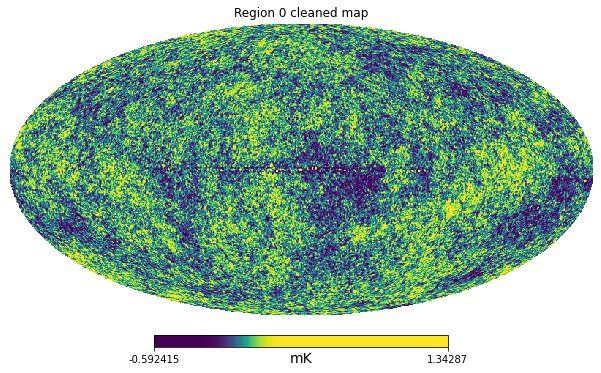

In [15]:
CMB_30_h  = harmonic_masked(CMB_30_p, LMAX, 0)
CMB_70_h  = harmonic_masked(CMB_70_p, LMAX, 0)
CMB_143_h = harmonic_masked(CMB_143_p, LMAX, 0)
CMB_353_h = harmonic_masked(CMB_353_p, LMAX, 0)

map_set = (CMB_30_h, CMB_70_h, CMB_143_h, CMB_353_h)     # to be used to generate the r0 weight

a = cov_inv(map_set)
weights = weight_gen(a)
print("The weights directly:",weights)

# this map is used as the input for the rest of the IILC

CMB_map = output_map(initial_hmaps, weights, LMAX, NSIDE)

hp.mollview((CMB_map * 10**3), unit='mK', norm='hist', title="Region 0 cleaned map")

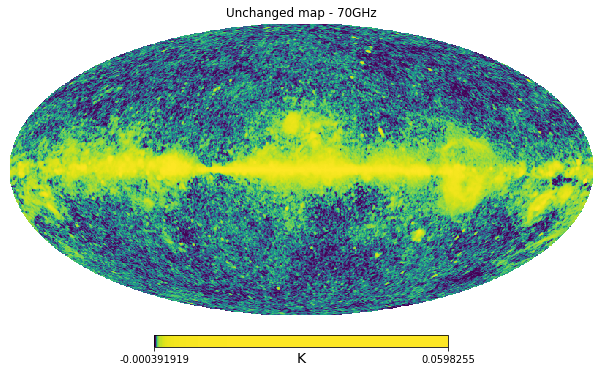

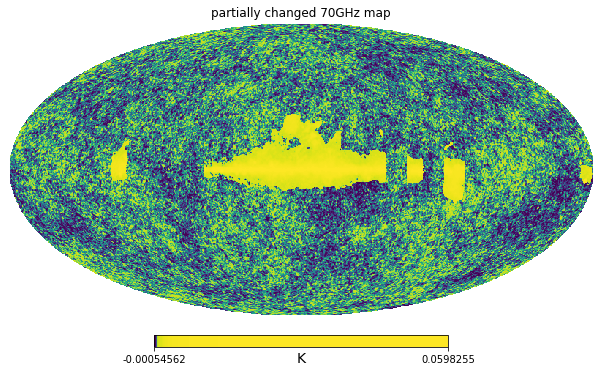

In [16]:
pmaps = (CMB_30_p, CMB_70_p, CMB_143_p, CMB_353_p)

pmaps_replaced = region_multi_replace(pmaps, CMB_map, 0)

chosen_map = 1  # 0 to 4 for the 30 to 353GHz maps

hp.mollview(((np.stack(pmaps))[chosen_map,:]), unit='K', norm='hist', title="Unchanged map - 70GHz")
hp.mollview((pmaps_replaced[chosen_map,:]), unit='K', norm='hist', title="partially changed 70GHz map")

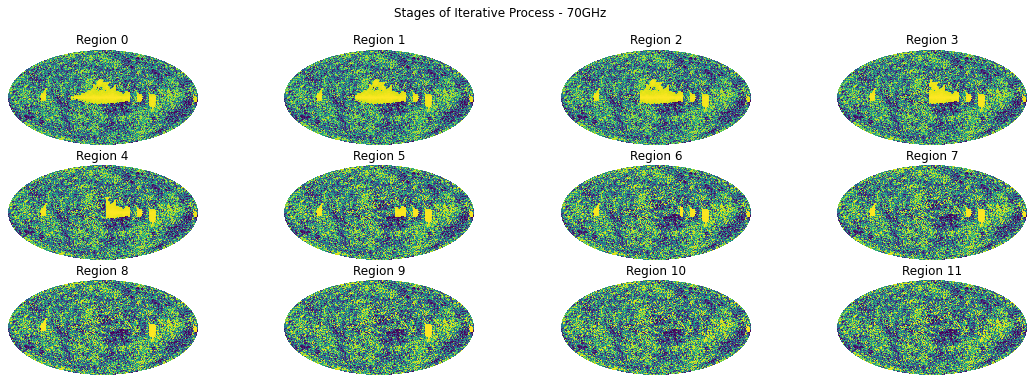

In [17]:
names = ["Region 0","Region 1","Region 2","Region 3","Region 4","Region 5","Region 6",
        "Region 7","Region 8","Region 9","Region 10","Region 11","Region 12"]

fig = plt.figure(figsize=(19,6))
plt.suptitle("Stages of Iterative Process - 70GHz")
plt.subplot(3,4,1)
hp.mollview((pmaps_replaced[chosen_map,:]), cbar=False, norm='hist', title="Region 0", hold=True)
    
for i in range(1,12):
    
    CMB_30_h  = harmonic_masked(pmaps_replaced[0,:], LMAX, i)
    CMB_70_h  = harmonic_masked(pmaps_replaced[1,:], LMAX, i)
    CMB_143_h = harmonic_masked(pmaps_replaced[2,:], LMAX, i)
    CMB_353_h = harmonic_masked(pmaps_replaced[3,:], LMAX, i)

    map_set = (CMB_30_h, CMB_70_h, CMB_143_h, CMB_353_h)
    weights = weight_gen(cov_inv(map_set))
    CMB_map = output_map(map_set, weights, LMAX, NSIDE)

    pmaps_replaced = region_multi_replace(pmaps_replaced, CMB_map, i)
    
    
    if 1==1:
        plt.subplot(3,4,i+1)
        hp.mollview((pmaps_replaced[chosen_map,:]), cbar=False, norm='hist', title=names[i], hold=True)
    else:
        hp.mollview((pmaps_replaced[chosen_map,:]), cbar=False, norm='hist', title=names[i])

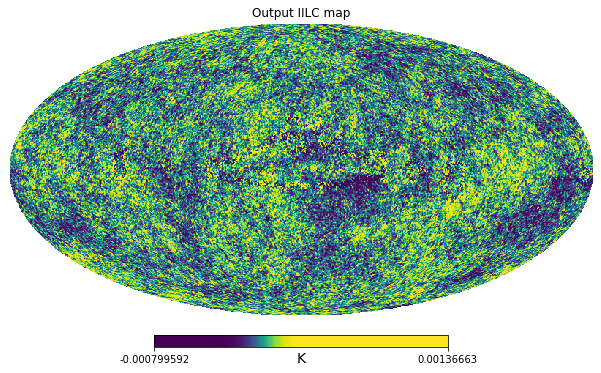

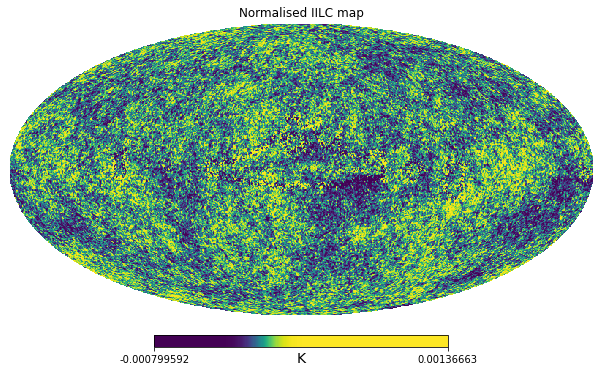

In [18]:
full_clean_maps = pmaps_replaced[3] 

# this should be the same for all 4 maps, all regions of all maps were replaced
# the change is due to the difference in FWHM - best to use the low or high frequency map as a comparison?

hp.mollview((full_clean_maps), unit='K', norm='hist', title="Output IILC map")

normalised_CMB_map = full_clean_maps / sum_all_blurred

hp.mollview((normalised_CMB_map), unit='K', norm='hist', title="Normalised IILC map")

In [20]:
if synthetic==1:
    hp.write_map("IILC_1y_synth_sm.fits", normalised_CMB_map, overwrite=True)

/home/idies/miniconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
